# Project: Predicting Car Prices

## Goal
In this project, we'll use a machine learning workflow to predict a car's market price using its attributes. 

## Data set
The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. You can find more about the data set [here](https://archive.ics.uci.edu/ml/datasets/automobile)

In [1]:
# import some libs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set_palette('Paired', 13)
pd.options.display.max_columns = 99

In [2]:
# The dataset doesn't contain the column name
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
# Read data
cars = pd.read_csv('imports-85.data',names=cols)
cars.head()

symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  length  width  \
0  convertible          rwd           front        88.6   168.8   64.1   
1  convertible          rwd           front        88.6   168.8   64.1   
2    hatchback          rwd           front        94.5   171.2   65.5   
3        sedan          fwd           front        99.8   176.6   66.2   
4        sedan          4wd           front        99.4   176.6   66.4   

   height  curb-weight engine-type num-of-cylinders  engine-size fuel-system  \
0    48.8         2548        dohc             four          130        mpfi   
1    48.8         2548        dohc             four          130        mpfi   
2    52.4         2823        ohcv              six          152        mpfi   
3    54.3         2337         ohc             four          109        mpfi   
4    54.3         2824         ohc             five          136        mpfi   

   bore stroke  compression-rate horsepower peak-rpm  city-mpg  highway-mpg  \
0  3.47   2.68               9.0        111     5000        21           27   
1  3.47   2.68               9.0        111     5000        21           27   
2  2.68   3.47               9.0        154     5000        19           26   
3  3.19   3.40              10.0        102     5500        24           30   
4  3.19   3.40               8.0        115     5500        18           22   

   price  
0  13495  
1  16500  
2  16500  
3  13950  
4  17450

Which columns are numeric and can be used as features and which column is the target column?

In [3]:
# Which columns are numeric?
cars.dtypes.value_counts()

object     16
int64       5
float64     5
dtype: int64

In [4]:
cars.dtypes[(cars.dtypes=='int64') | (cars.dtypes=='float64')].index

Index(['symboling', 'wheel-base', 'length', 'width', 'height', 'curb-weight',
       'engine-size', 'compression-rate', 'city-mpg', 'highway-mpg'],
      dtype='object')

We want continuous values. 

We drop off from this list the 'symboling' (a discrete value) value and we need to add other values (labeled as object) like:
* normalized-losses
* bore
* stroke
* horsepower
* peak-rpm
* price

In [5]:
# Select only the columns with continuous values 
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]
numeric_cars.head()

normalized-losses  wheel-base  length  width  height  curb-weight  \
0                 ?        88.6   168.8   64.1    48.8         2548   
1                 ?        88.6   168.8   64.1    48.8         2548   
2                 ?        94.5   171.2   65.5    52.4         2823   
3               164        99.8   176.6   66.2    54.3         2337   
4               164        99.4   176.6   66.4    54.3         2824   

   engine-size  bore stroke  compression-rate horsepower peak-rpm  city-mpg  \
0          130  3.47   2.68               9.0        111     5000        21   
1          130  3.47   2.68               9.0        111     5000        21   
2          152  2.68   3.47               9.0        154     5000        19   
3          109  3.19   3.40              10.0        102     5500        24   
4          136  3.19   3.40               8.0        115     5500        18   

   highway-mpg  price  
0           27  13495  
1           27  16500  
2           26  16500  
3           30  13950  
4           22  17450

## Data Cleaning

We usually can't have any missing values if we want to use them for predictive modeling. Based on the data set preview, we can tell that the normalized-losses column contains missing values represented using "?". Let's replace these values by NaN and look for the presence of missing values in other numeric columns. 

In [6]:
numeric_cars = numeric_cars.replace('?', np.nan)

The columns labelled as object contain values with differents types (like for normalized-losses with had string value -?- and num value). Let's explore the other object columns

In [7]:
object_col=numeric_cars.dtypes[numeric_cars.dtypes=='object'].index
object_col

Index(['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm',
       'price'],
      dtype='object')

In [8]:
for c in object_col:
    print('{} has these values \n {} \n'.format(c,numeric_cars[c].value_counts(dropna=False)))

normalized-losses has these values 
 NaN    41
161    11
91      8
150     7
104     6
128     6
134     6
85      5
168     5
102     5
94      5
65      5
74      5
103     5
95      5
122     4
148     4
118     4
93      4
106     4
125     3
154     3
83      3
137     3
101     3
115     3
194     2
108     2
158     2
87      2
192     2
113     2
197     2
81      2
145     2
89      2
164     2
110     2
153     2
129     2
188     2
119     2
90      1
142     1
78      1
256     1
77      1
231     1
98      1
186     1
121     1
107     1
Name: normalized-losses, dtype: int64 

bore has these values 
 3.62    23
3.19    20
3.15    15
3.03    12
2.97    12
3.46     9
3.31     8
3.78     8
3.43     8
2.91     7
3.27     7
3.58     6
3.05     6
3.39     6
3.54     6
3.01     5
3.70     5
3.35     4
NaN      4
3.74     3
3.17     3
3.59     3
3.24     2
3.47     2
3.33     2
3.80     2
3.63     2
3.50     2
3.13     2
3.94     2
2.68     1
2.54     1
3.34     1
2.92     1
3.61 

Everything seems normal. The Nan value is the reason why these columns are labeled as object.

In [9]:
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

the normalized-losses column has 41 rows with Nan value? 
How we should handle that? We could:
* Replace the missing values using the average values from that column.
* Drop the rows entirely (especially if other columns in those rows have missing values).
* Drop the column entirely.

As we are working with continuous values, the righ anwser could be use the average value to replace missing values.

However as we want to predcit the price of the car (it's our target column), we'll drop rows with missing values in price.

In [10]:
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars=numeric_cars.fillna(numeric_cars.mean())
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Now let's rescale the values in the numeric columns so they all range from 0 to 1, except the target column.

In [11]:
price_col=numeric_cars['price']

In [12]:
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars.head()

normalized-losses  wheel-base    length     width    height  curb-weight  \
0           0.298429    0.058309  0.413433  0.324786  0.083333     0.411171   
1           0.298429    0.058309  0.413433  0.324786  0.083333     0.411171   
2           0.298429    0.230321  0.449254  0.444444  0.383333     0.517843   
3           0.518325    0.384840  0.529851  0.504274  0.541667     0.329325   
4           0.518325    0.373178  0.529851  0.521368  0.541667     0.518231   

   engine-size      bore    stroke  compression-rate  horsepower  peak-rpm  \
0     0.260377  0.664286  0.290476            0.1250    0.294393  0.346939   
1     0.260377  0.664286  0.290476            0.1250    0.294393  0.346939   
2     0.343396  0.100000  0.666667            0.1250    0.495327  0.346939   
3     0.181132  0.464286  0.633333            0.1875    0.252336  0.551020   
4     0.283019  0.464286  0.633333            0.0625    0.313084  0.551020   

   city-mpg  highway-mpg     price  
0  0.222222     0.289474  0.207959  
1  0.222222     0.289474  0.282558  
2  0.166667     0.263158  0.282558  
3  0.305556     0.368421  0.219254  
4  0.138889     0.157895  0.306142

In [13]:
numeric_cars['price']=price_col

## Univariate Model

Let's start with some univariate k-nearest neighbors models.

Starting with simple models before moving to more complex models helps us structure your code workflow and understand the features better.

### Error metric
The metric we will use for this project is the Root Mean Squared Error (RMSE). Both, the MSE and RMSE are highly biased for higher values, but the RMSE is better in terms of reflecting performance when dealing with large error values.

In [14]:
def knn_train_test(train_col, target_col, df):
    """Function to train and test univariate models
    
    Args:
        train_col (str): training column nam
        target_col (str): target column name
        df (pandas dataframe): dataframe object
        
    Returns:
        float: the RMSE value of the prediction
    """
    knn=KNeighborsRegressor()
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index=np.random.permutation(df.index)
    rand_df=df.reindex(shuffled_index)
    
    # Divide number of rows in half and round.
    last_train_row=int(len(rand_df)/2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df=rand_df[:last_train_row]
    
    test_df=rand_df[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[train_col]], train_df[target_col])
    
    # Make predictions using model.
    predictions=knn.predict(test_df[[train_col]])
    
    # Calculate and return RMSE.
    mse=mean_squared_error(test_df[target_col],predictions)
    rmse=np.sqrt(mse)
    
    return rmse

We'll use this function to train and test univariate models using the different numeric columns in the data set. Which column performed the best using the default k value?

In [15]:
rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

In [16]:
# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

In [17]:
# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results).sort_values(ascending=False)
rmse_results_series

height               8144.441043
stroke               8006.529545
peak-rpm             7697.459696
normalized-losses    7330.197653
bore                 6780.627785
compression-rate     6610.812153
wheel-base           5461.553998
length               5427.200961
city-mpg             4766.422505
width                4704.482590
highway-mpg          4630.026799
curb-weight          4401.118255
horsepower           4037.037713
engine-size          3238.462830
dtype: float64

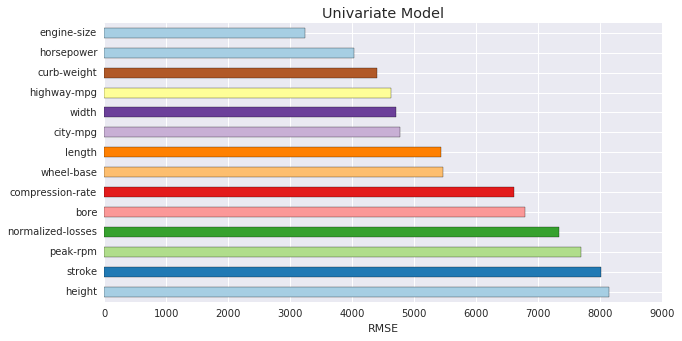

In [18]:
rmse_results_series.plot.barh(figsize=(10,5))
plt.title('Univariate Model', fontsize='x-large')
plt.xlabel('RMSE')
#sns.despine()

the engine-size value performed the best in this case.

Now we'll modify our function to accept a parameter for the k value

In [19]:
def knn_train_test(train_col, target_col, df, kValues):
    """Function to train and test univariate models
    
    Args:
        train_col (str): training column nam
        target_col (str): target column name
        df (pandas dataframe): dataframe object
        k (list of int): the k-values for the model
        
    Returns:
        float: the RMSE value of the prediction
    """
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index=np.random.permutation(df.index)
    rand_df=df.reindex(shuffled_index)
    
    # Divide number of rows in half and round.
    last_train_row=int(len(rand_df)/2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df=rand_df[:last_train_row]
    
    test_df=rand_df[last_train_row:]
    
    k_rmses={}
    for k in kValues:
        knn=KNeighborsRegressor(n_neighbors=k)
        # Fit a KNN model using default k value.
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predictions=knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse=mean_squared_error(test_df[target_col],predictions)
        rmse=np.sqrt(mse)
        k_rmses[k]=rmse
    
    return k_rmses

In [20]:
k_rmse_results = {}
k_values = [1,3,5,7,9]

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars,k_values)
    k_rmse_results[col] = rmse_val

In [21]:
for k,v in sorted(k_rmse_results.items()):
    print(k,v, '\n')

bore {1: 8602.58848450066, 3: 6984.239489480916, 9: 6866.808502038413, 5: 6780.627784685976, 7: 6878.097965921532} 

city-mpg {1: 5901.143574354764, 3: 4646.746408727155, 9: 5465.209492527533, 5: 4766.422505090134, 7: 5232.523034167316} 

compression-rate {1: 8087.205346523092, 3: 7375.063685578359, 9: 7024.485525463435, 5: 6610.812153159129, 7: 6732.801282941515} 

curb-weight {1: 5264.290230758878, 3: 5022.318011757233, 9: 4632.044474454401, 5: 4401.118254793124, 7: 4330.608104418053} 

engine-size {1: 3258.4861059962027, 3: 2840.562805643501, 9: 3831.8244149840766, 5: 3238.4628296477176, 7: 3563.086774256415} 

height {1: 8904.04645636071, 3: 8277.609643045525, 9: 7811.03606291223, 5: 8144.441042663747, 7: 7679.598124393773} 

highway-mpg {1: 6025.594966720739, 3: 4617.305019788554, 9: 5278.358056953987, 5: 4630.026798588056, 7: 4796.061440186946} 

horsepower {1: 4170.054848037801, 3: 4020.8492630885394, 9: 4515.135617419103, 5: 4037.0377131537603, 7: 4353.811860277134} 

length {1

To have a better feeling about our results we'll plot them for visualization

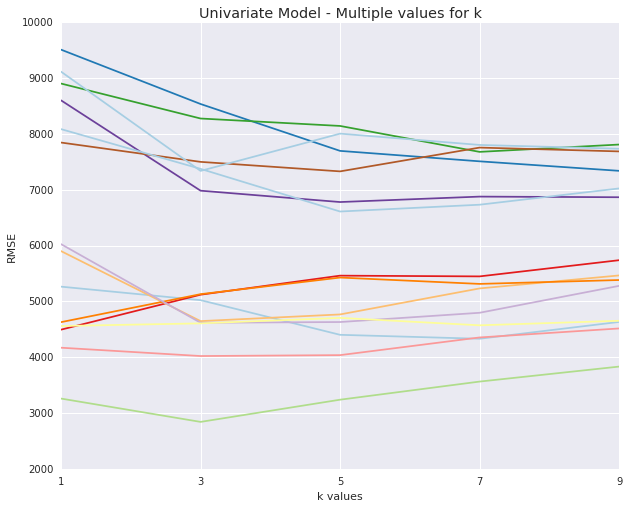

In [22]:
fig = plt.figure(figsize=(10,8))
for k,v in k_rmse_results.items():
    x=list()
    y=list()
    for i in sorted (v) : 
        x.append(i)
        y.append(v[i])
    
    # The solution below don't work because keys is unordered.
    #x = list(v.keys())
    #y = list(v.values())
    
    plt.plot(x,y)
    
    plt.xlabel('k values')
    plt.ylabel('RMSE')
plt.xlim(1)
plt.xticks([1,3,5,7,9])
plt.title('Univariate Model - Multiple values for k', fontsize='x-large')
#plt.legend([k for k in k_rmse_results.keys()], bbox_to_anchor=(1, 1))
#sns.despine()

## Multivariate Model

Let's modify the knn_train_test() function we wrote in the last step to work with multiple columns.

In [23]:
def knn_train_test(train_col, target_col, df, kValues):
    """Function to train and test multivariate models
    
    Args:
        train_col (list of str): training column names
        target_col (str): target column name
        df (pandas dataframe): dataframe object
        k (list of int): the k-values for the model
        
    Returns:
        float: the RMSE value of the prediction
    """
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index=np.random.permutation(df.index)
    rand_df=df.reindex(shuffled_index)
    
    # Divide number of rows in half and round.
    last_train_row=int(len(rand_df)/2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df=rand_df[:last_train_row]
    
    test_df=rand_df[last_train_row:]
    
    k_rmses={}
    for k in kValues:
        knn=KNeighborsRegressor(n_neighbors=k)
        # Fit a KNN model using default k value.
        knn.fit(train_df[train_col], train_df[target_col])

        # Make predictions using model.
        predictions=knn.predict(test_df[train_col])

        # Calculate and return RMSE.
        mse=mean_squared_error(test_df[target_col],predictions)
        rmse=np.sqrt(mse)
        k_rmses[k]=rmse
    
    return k_rmses

In [24]:
# Compute average RMSE across different `k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index

engine-size          3346.484586
horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64


In [25]:
k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars,
        [5]
    )

k_rmse_results

{'2 best features': {5: 2949.8817277180374},
 '3 best features': {5: 3580.7376651928435},
 '4 best features': {5: 3487.340917327035},
 '5 best features': {5: 3410.2170133901805},
 '6 best features': {5: 3478.510890118539}}

The best rmse value is achieved with 2 features

## Hyperparameter Tuning
We will vary the hyperparameter value from 1 to 25 and plot the resulting RMSE values.

In [26]:
k_values = [i for i in range(1, 25)]

k_rmse_results = {}

for nr_best_feats in range(2,6):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars,
        k_values
    )

k_rmse_results

{'2 best features': {1: 2783.6204237227344,
  2: 2657.7963807419765,
  3: 2792.586573031673,
  4: 2891.5329686923255,
  5: 2949.8817277180374,
  6: 3096.402601694776,
  7: 3164.681969020496,
  8: 3413.228359192009,
  9: 3748.6716603306486,
  10: 4080.7125057341937,
  11: 4215.6372280600335,
  12: 4275.421524277872,
  13: 4373.901683035496,
  14: 4424.285137239815,
  15: 4539.505493095937,
  16: 4667.307671446768,
  17: 4729.605305844226,
  18: 4790.556632159094,
  19: 4824.3866193292615,
  20: 4840.850914693829,
  21: 4837.429062000271,
  22: 4831.16988267597,
  23: 4861.679492959275,
  24: 4903.346008862579},
 '3 best features': {1: 3399.8148100410203,
  2: 3497.191103423058,
  3: 3333.6966577570593,
  4: 3355.8842294742026,
  5: 3580.7376651928435,
  6: 3732.943016673517,
  7: 3639.9439408462786,
  8: 3747.4209132113137,
  9: 3986.593913133887,
  10: 4005.354888715163,
  11: 4121.687230061635,
  12: 4255.700651624227,
  13: 4328.476829895253,
  14: 4332.216494947217,
  15: 4388.22571

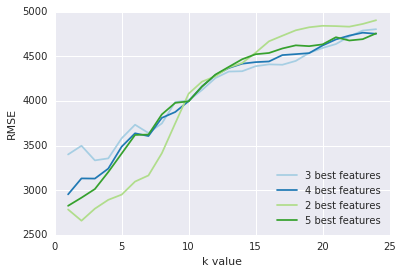

In [27]:
for k,v in k_rmse_results.items():
    x=list(v.keys())
    y=list(v.values())
    
    plt.plot(x,y,label=k)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.legend(loc=4)

Depending the model we used the optimal k change:
* for 2: we have the k value is optimal at 2
* for 3 at 3
* for 4 and 5 at 1

Since our dataset is pretty small (only 201 entries), bigger values for k make increase rapidly the variance of the model. Therefore, the model will not generalize well outside the training set.

## Next Steps
Here are some ideas for next steps:

* Modify the knn_train_test() function to use k-fold cross validation instead of test/train validation.

* Modify the knn_train_test() function to perform the data cleaning as well.